### Transfer Learning with TensorFlow Part 

Main benefits to use transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own.


### Initializing GPU

In [ ]:
!nvidia-smi

Tue Oct 25 05:34:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Using Transfer learning with `tensorflowhub`

### Downloading Data


In [1]:
# Get the data
import zipfile

# Download Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the data
zipref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zipref.extractall()
zipref.close()

--2022-10-26 09:13:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.251.18.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  96.4MB/s    in 1.7s    

2022-10-26 09:13:27 (96.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Seeing, How many images are in each folder
import os

# Walkthrough 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

### Creating data loaders (preparing the data)
Now we've downloaded the data, let's use the `ImageDataGenerator` class along with the flow_from_directory method to load in our images.

In [ ]:
# Setup the inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE =(224, 224)
BATCH_SIZE = (32)

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                           target_size = IMAGE_SHAPE,
                                           batch_size = BATCH_SIZE,
                                           class_mode = "categorical")



Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains)

We are gonna be using:-
* Experiment tracking with TensorBoard
* Model Checkpointing
* Early Stopping 

> 🔑 **Note:** We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance.

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d%-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Because we're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:
* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now)

> 🔑 **Note:** Depending on our use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you or your team can understand them.



### Creating models using TensorFlow Hub
In fact, we're going to use two models from TensorFlow Hub:
1. ResNetV2 - a CV model from 2016.
2. EfficientNet -  a CV architecture from 2019.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficienNetB0 feature vector(version 1)
efficient_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [ ]:
def create_model(model_url, num_classes = 10):
  """
  Takes a Tensorflow HUB url and creates a Keras Sequential mdoel with it.
  Args:
    model_url (str): TF HUB feature extraction URL.
    num_classes (int): number of output neurons in output layer,
    should be equal to number of tarfer classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes outputs.
  """

  # Download the pretrained model and save it as Keras layer.
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,))
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  # Add tensorboard callback to the model
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221025%H3451
Epoch 1/5
24/24 [==============================] - 30s 761ms/step - loss: 1.9534 - accuracy: 0.3413 - val_loss: 1.2264 - val_accuracy: 0.6032
Epoch 2/5
24/24 [==============================] - 17s 722ms/step - loss: 0.9044 - accuracy: 0.7253 - val_loss: 0.8629 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - 16s 685ms/step - loss: 0.6194 - accuracy: 0.8293 - val_loss: 0.7451 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 17s 714ms/step - loss: 0.4798 - accuracy: 0.8787 - val_loss: 0.7114 - val_accuracy: 0.7664
Epoch 5/5
24/24 [==============================] - 16s 683ms/step - loss: 0.3840 - accuracy: 0.9120 - val_loss: 0.6812 - val_accuracy: 0.7724


### Checking model's training curves 

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validaiton metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

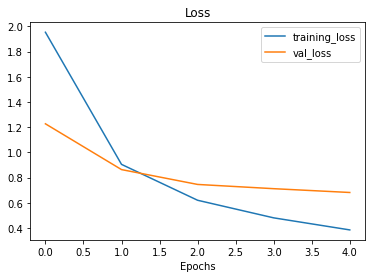

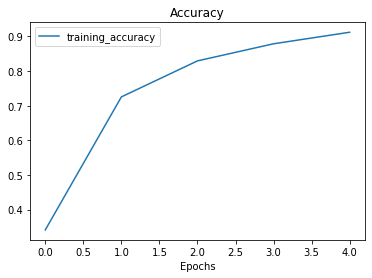

In [ ]:
plot_loss_curves(resnet_history)

### Model Summary

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


 Doing same with  Efficient NetBO model

In [ ]:
# create model
efficient_model = create_model(model_url = efficient_url, num_classes = train_data_10_percent.num_classes)

# Compile Efficient model
efficient_model.compile(loss = 'categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])
# Fitting the model
efficient_history = efficient_model.fit(train_data_10_percent,
                                        epochs = 5,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name = 'tensorflow+hub',
                                                                                 experiment_name = "efficientnetB0")])


Saving TensorBoard log files to: tensorflow+hub/efficientnetB0/20221025%H3638
Epoch 1/5
24/24 [==============================] - 23s 706ms/step - loss: 1.9869 - accuracy: 0.3453 - val_loss: 1.5382 - val_accuracy: 0.5924
Epoch 2/5
24/24 [==============================] - 15s 653ms/step - loss: 1.3039 - accuracy: 0.6653 - val_loss: 1.1418 - val_accuracy: 0.6964
Epoch 3/5
24/24 [==============================] - 15s 648ms/step - loss: 1.0059 - accuracy: 0.7667 - val_loss: 0.9623 - val_accuracy: 0.7376
Epoch 4/5
24/24 [==============================] - 15s 645ms/step - loss: 0.8416 - accuracy: 0.7947 - val_loss: 0.8692 - val_accuracy: 0.7484
Epoch 5/5
24/24 [==============================] - 15s 646ms/step - loss: 0.7342 - accuracy: 0.8333 - val_loss: 0.8090 - val_accuracy: 0.7592


In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=np5FDk4VFdFR8qLwPweWO7mgzRddcx&prompt=consent&access_type=off

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/iAKTXIYpRxuqPQn8rqlzjQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   iAKTXIYpRxuqPQn8rqlzjQ
	Created              2022-10-25 05:49:21 (5 minutes ago)
	Updated              2022-10-25 05:49:22 (5 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1843536
Total: 1 experiment(s)


In [ ]:
# Deleting the experiment
!tensorboard dev delete --experiment_id iAKTXIYpRxuqPQn8rqlzjQ

Deleted experiment iAKTXIYpRxuqPQn8rqlzjQ.


In [ ]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
